# Model Training
## 1. Import Data and Required Packages
### Importing Pandas, Numpy, Matplotlib, Seaborn, Scikit-Learn and Warings Library.

In [138]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

## 2. Import the CSV Data as Pandas DataFrame

In [139]:
df = pd.read_csv('clean_data.csv')
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 3. Based on EDA, these points are important for Model Building

### 3.1. In this dataset, loan_status is our Target Feature
#### → • We are dividing the data into two parts: Independent Features (X) and Target Feature (Y)

### 3.2. Some features are not normally distributed, such as loan_amount, residential_assets_value, commercial_assets_value, luxury_assets_value, and bank_assets_value.
#### → • Perform **transformations, such as logarithmic or square root transformations**, to convert non-normal distributions into approximately normal distributions.

### 3.3. Our data has three categorical features: education, self_employed, and loan_status.
#### → • Perform **encoding, such as One-Hot Encoder, Label Encoder or Target Encoder**, to convert categorical columns into numeric columns.

### 3.4. loan_status shows that 62.2% of applicants are Approved, and 37.8% are Rejected. This indicates that the data is imbalanced.
#### → • Perform **SMOTE** to balance the imbalanced data.

## 3.1. Preparing X and y variables

### 3.1.1 (X) Dataset

In [140]:
X = df.drop('loan_status',axis=1)
X.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000


### 3.1.2 (y) Dataset

In [141]:
y = df['loan_status']
y.unique()

array(['Approved', 'Rejected'], dtype=object)

### 3.1.3 Converting loan_status columns into numeric

In [142]:
target_encoder = LabelEncoder()
target_encoder.fit_transform(y)
y = target_encoder.transform(y)
y

array([0, 1, 1, ..., 1, 0, 0])

## 3.2 Applying Square root Transformation to Reduce Skewness

### 3.2.1 Find numeric columns and categorical columns

In [143]:
numeric_col = list(X.select_dtypes(include='int').columns)
categorical_col = list(X.select_dtypes(include='object').columns)
print(f"Numeric Columns :- ",numeric_col)
print(f"Categorical Columns :- ",categorical_col)

Numeric Columns :-  ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical Columns :-  ['education', 'self_employed']


### 3.2.2 Visualizing the Natural Distribution of Numerical Features

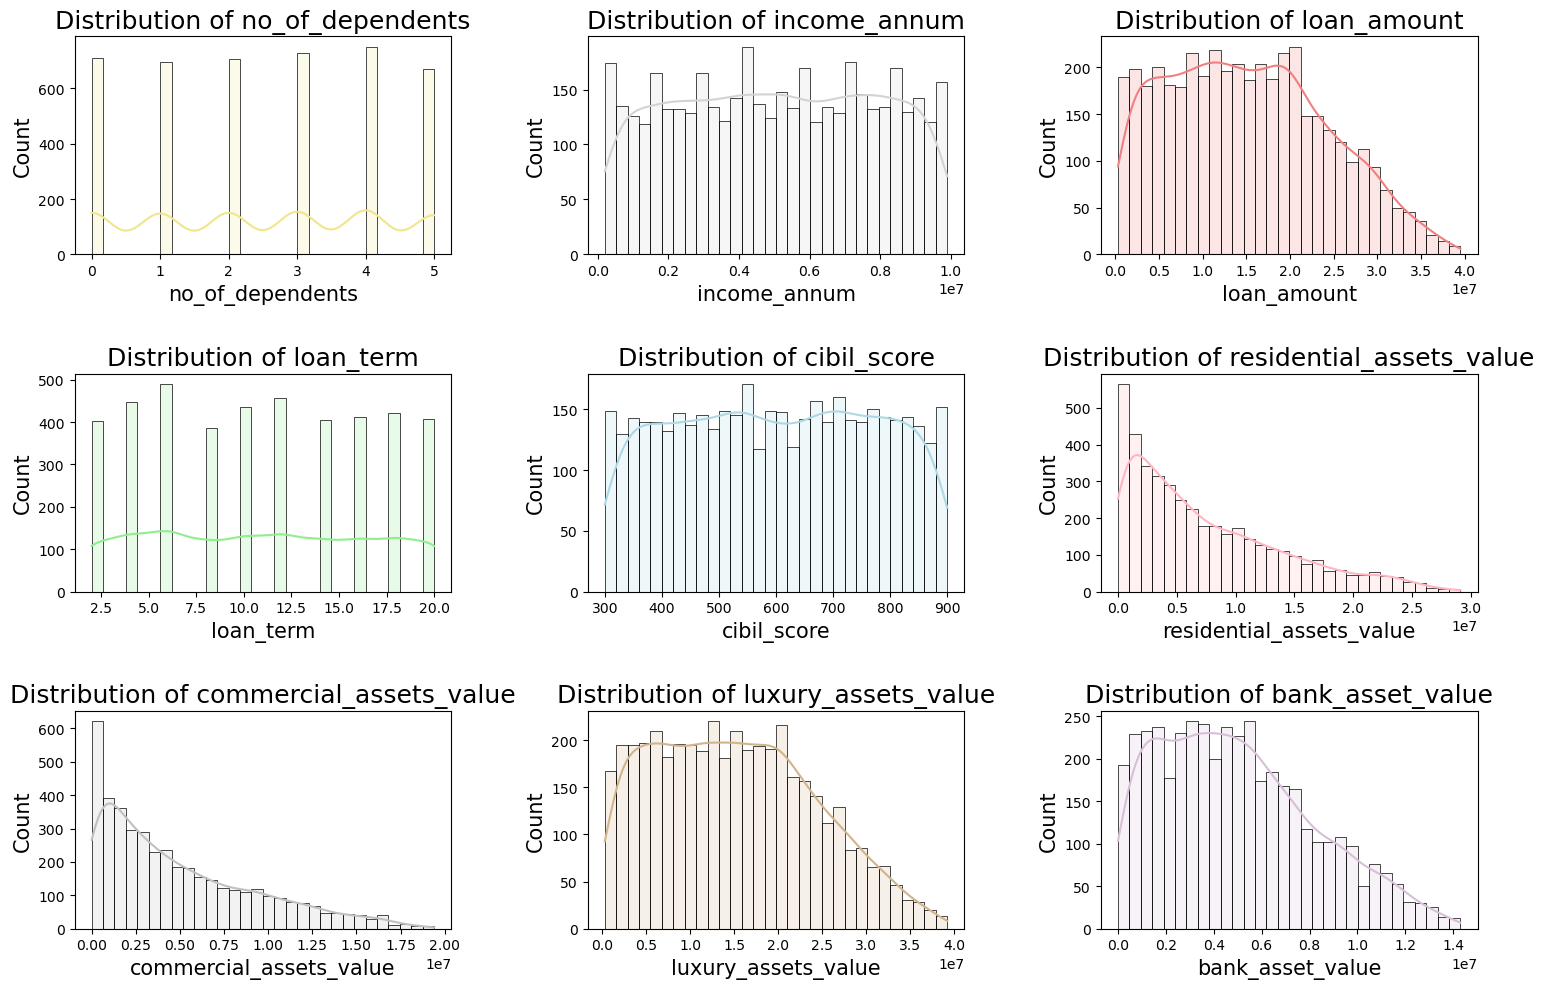

In [144]:
count=0
plt.figure(figsize=(15,10))
for col in numeric_col:
    colors =  ['khaki','lightgrey','lightcoral','lightgreen','lightblue','lightpink','silver','tan','thistle']
    plt.subplot(3,3,count+1)
    sns.histplot(x=col,data=X,bins=30,kde=True,color=colors[count],edgecolor='black',linewidth=0.5,alpha=0.2)
    plt.title(f"Distribution of {col}",fontsize=18)
    plt.xlabel(col,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    count+=1
plt.tight_layout(w_pad=5,h_pad=3)
plt.show()
    

- Most asset-related features (loan_amount, commercial_assets_value, luxury_assets_value, bank_asset_value, residential_assets_value)    
  are heavily right-skewed, meaning most applicants have relatively low asset values, while only a few applicants have very high asset values.     
  This suggests potential outliers and indicates that transformations like log or square-root could help normalize these features for modeling.    

- Features like no_of_dependents, income_annum, loan_term, and cibil_score are relatively uniform     
  or normally distributed, so transformations are not needed for them.

### 3.2.3 Perform sqrt Transformation

In [145]:
for col in ['loan_amount', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']:
    X[col] = np.sqrt(X[col])

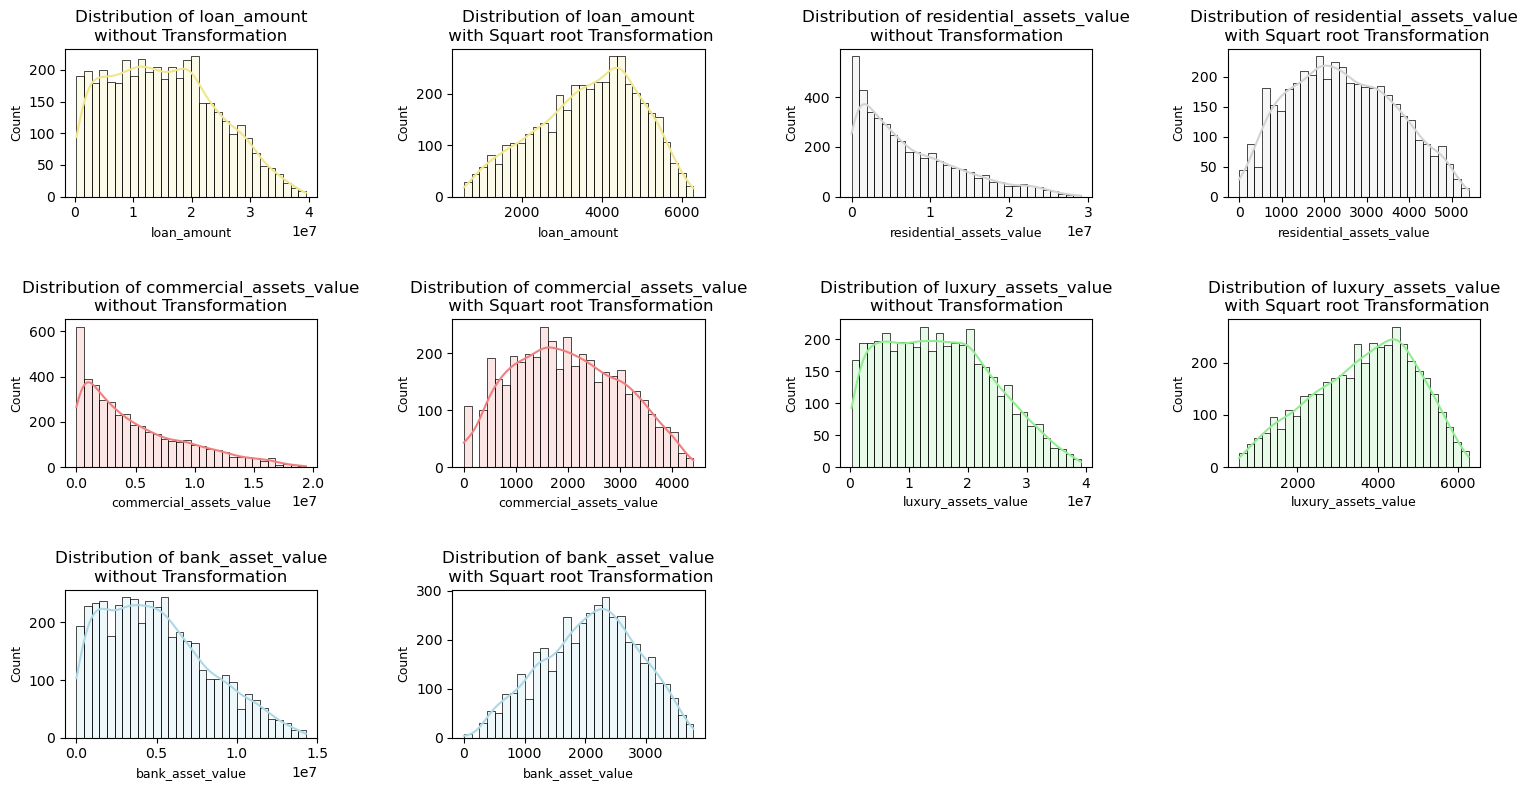

In [146]:
count=0
plt.figure(figsize=(15,8))
for col in ['loan_amount', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']:
    colors =  ['khaki','khaki','lightgrey','lightgrey','lightcoral','lightcoral','lightgreen','lightgreen','lightblue','lightblue']
    plt.subplot(3,4,count+1)
    sns.histplot(x=col,data=df,bins=30,kde=True,color=colors[count],edgecolor='black',linewidth=0.5,alpha=0.2)
    plt.title(f"Distribution of {col}\nwithout Transformation",fontsize=12)
    plt.xlabel(col,fontsize=9)
    plt.ylabel("Count",fontsize=9)
    count+=1
    plt.subplot(3,4,count+1)
    sns.histplot(x=col,data=X,bins=30,kde=True,color=colors[count],edgecolor='black',linewidth=0.5,alpha=0.2)
    plt.title(f"Distribution of {col}\n with Squart root Transformation",fontsize=12)
    plt.xlabel(col,fontsize=9)
    plt.ylabel("Count",fontsize=9)
    count+=1
plt.tight_layout(w_pad=5,h_pad=3)
plt.show()
    

- All asset-related features (loan amount, residential_assets_value, commercial_assets_value, luxury_assets_value, bank_asset_value)
  are heavily right-skewed without transformation.

- After applying a square root transformation, the distributions become much more **symmetric and closer to normal**.

## 4. Create Column Transformer with One_Hot_Encoder and Standard_Scaler

In [147]:
One_Hot_Encoder = OneHotEncoder()
standard_scaler = StandardScaler()
preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',One_Hot_Encoder,categorical_col),
        ('StandardScaler',standard_scaler,numeric_col)
    ]
)

In [148]:
X  = preprocessor.fit_transform(X)

In [149]:
X.shape

(4264, 13)

In [150]:
X[0:5]

array([[ 1.        ,  0.        ,  1.        ,  0.        , -0.2938615 ,
         1.62178955,  1.40338144,  0.19345066,  1.03184207, -0.72033418,
         2.15063941,  0.85311576,  0.94740879],
       [ 0.        ,  1.        ,  0.        ,  1.        , -1.47373478,
        -0.34013226, -0.1396628 , -0.50767438, -1.06191052, -0.64413498,
        -0.47634534, -0.54613802, -0.3437383 ],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.29607514,
         1.44343302,  1.38907106,  1.59570072, -0.54572221,  0.1840805 ,
         0.14173386,  1.63615236,  1.90352415],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.29607514,
         1.12239127,  1.46014985, -0.50767438, -0.77191709,  1.48271005,
        -0.15344412,  0.90179907,  0.92478039],
       [ 0.        ,  1.        ,  0.        ,  1.        ,  1.47594842,
         1.69313216,  0.97470954,  1.59570072, -1.26490593,  0.87880231,
         0.86071115,  1.36498359,  0.19153323]])

In [151]:
y[0:5]

array([0, 1, 1, 1, 1])

## 5. This Dataset are Imbalanced 

### 5.1 Countplot of Imbalanced data

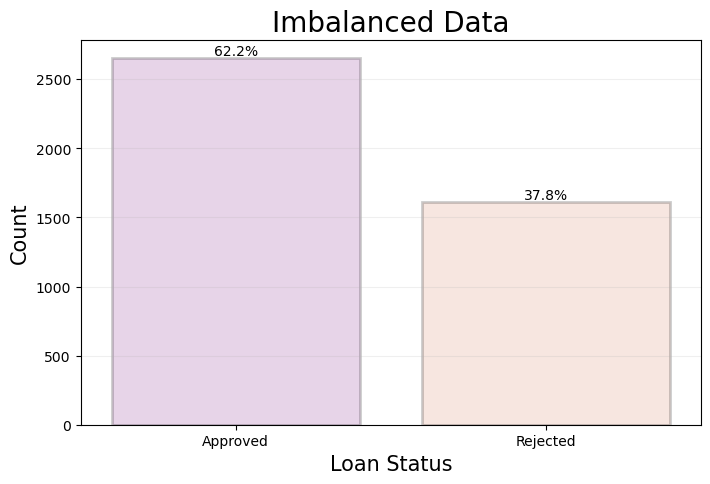

In [152]:
plt.figure(figsize=(8,5))
ax=sns.countplot(x='loan_status',data=df,palette='plasma',alpha=0.2,edgecolor='black',linewidth=2)
for p in ax.patches:
    total = len(df['loan_status'])
    percentage = (p.get_height() / total) * 100
    ax.annotate(f'{percentage:.1f}%',(p.get_x() + p.get_width()/2, p.get_height()),ha='center',va='bottom')
plt.title("Imbalanced Data",fontsize=20)
plt.xlabel("Loan Status",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.grid(axis='y', alpha=0.2)
plt.show()

- The dataset shows a class imbalance, with 62.2% approved loans and 37.8% rejected loans.

### 5.2 Now, we are balancing the data.

In [153]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)
print(f"X_resampled :- {X_resampled.shape}")
print(f"y_resampled :- {y_resampled.shape}")

X_resampled :- (5308, 13)
y_resampled :- (5308,)


- Based on EDA, the dataset initially contained 4,269 samples. After applying SMOTE,   
  the dataset size increased to 5,308 due to synthetic samples generated for the minority class.

### 5.3 Countplot for Balanced Data

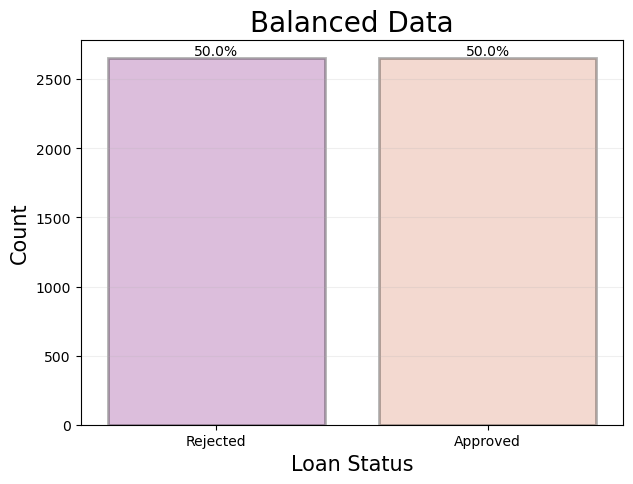

In [154]:
y_for_plot = pd.DataFrame(y_resampled)
y_for_plot = y_for_plot.iloc[:,0].map({1:'Approved',0:'Rejected'})
plt.figure(figsize=(7,5))
ax = sns.countplot(x=y_for_plot,palette='plasma',alpha=0.3,edgecolor='black',linewidth=2)
for p in ax.patches:
    total = len(y_for_plot)
    percentage = (p.get_height() / total) * 100
    ax.annotate(f'{percentage:.1f}%',(p.get_x() + p.get_width()/2.0,p.get_height()),ha='center',va='bottom')
plt.title("Balanced Data",fontsize=20)
plt.xlabel("Loan Status",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.grid(axis='y', alpha=0.2)
plt.show()

- Now, our data are ***balanced***.

## 6. Separate dataset into train and test

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)

In [159]:
print(f"X train :- ",X_train.shape)
print(f"y_train :- ",y_train.shape)
print(f"X_test  :- ",X_test.shape)
print(f"y_test  :- ",y_test.shape)

X train :-  (4246, 13)
y_train :-  (4246,)
X_test  :-  (1062, 13)
y_test  :-  (1062,)


## 7. Create an Evaluate Function to give all metrics after model Training

In [212]:
def evaluate_model(actual,predict):
    accuracyscore = accuracy_score(actual,predict) 
    classificationreport = classification_report(actual,predict)
    precisionscore = precision_score(actual,predict)
    recallscore = recall_score(actual,predict)
    f1score = f1_score(actual,predict)
    return accuracyscore, classificationreport, precisionscore, recallscore, f1score

In [220]:
models = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'SVC' : SVC(),
    'Random Forest' : RandomForestClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
    'Gradient Boosting' : GradientBoostingClassifier(),
    'KNN' : KNeighborsClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    accuracyscore_train, classificationreport_train, precisionscore_train, recallscore_train, f1score_train = evaluate_model(y_train, y_train_pred)
    accuracyscore_test, classificationreport_test, precisionscore_test, recallscore_test, f1score_test = evaluate_model(y_test,y_test_pred)
    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy Score :- {:.4f}".format(accuracyscore_train))
    print("- Classification Report :- \n",classificationreport_train)
    print("- Precision Score :- {:.4f}".format(precisionscore_train))
    print("- Recall Score :- {:.4f}".format(recallscore_train))
    print("- f1 Score :- {:.4f}".format(f1score_train))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy Score :- {:.4f}".format(accuracyscore_test))
    print("- Classification Report :- \n",classificationreport_test)
    print("- Precision Score :- {:.4f}".format(precisionscore_test))
    print("- Recall Score :- {:.4f}".format(recallscore_test))
    print("- f1 Score :- {:.4f}".format(f1score_test))
    
    print('='*35)
    print('\n')

Logistic Regression
Model performance for Training set
- Accuracy Score :- 0.9331
- Classification Report :- 
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      2135
           1       0.92      0.95      0.93      2111

    accuracy                           0.93      4246
   macro avg       0.93      0.93      0.93      4246
weighted avg       0.93      0.93      0.93      4246

- Precision Score :- 0.9185
- Recall Score :- 0.9498
- f1 Score :- 0.9339
----------------------------------
Model performance for Test set
- Accuracy Score :- 0.9350
- Classification Report :- 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       519
           1       0.93      0.95      0.94       543

    accuracy                           0.94      1062
   macro avg       0.94      0.93      0.93      1062
weighted avg       0.94      0.94      0.94      1062

- Precision Score :- 0.9263
- Recall Sc

'Logistic Regression'